In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from scipy.stats import ttest_ind
import shap

In [4]:
# Step 1: Load and Understand the Dataset
# Load the dataset
file_path = 'data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

In [5]:
# Step 2: Data Preprocessing
# 2.1 Handle Missing Values
data['ReasonsForLack'].fillna('No Reason', inplace=True)

# 2.2 Feature Encoding
categorical_columns = ['EducationSector', 'IndividualProject', 'Gender', 'City', 'Influenced', 'MentalDisorder', 'KeyTraits']
numerical_columns = ['Age', 'Perseverance', 'DesireToTakeInitiative', 'Competitiveness', 'SelfReliance', 
                     'StrongNeedToAchieve', 'SelfConfidence', 'GoodPhysicalHealth']

# One-Hot Encoding for categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(data[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns)

# 2.3 Feature Scaling for Numerical Features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(data[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

# 2.4 Combine All Features
processed_data = pd.concat([scaled_numerical_df, encoded_df, data['y']], axis=1)

# 2.5 Split Data into Training and Testing Sets
X = processed_data.drop(columns=['y'])
y = processed_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Dell\AppData\Local\Temp\ipykernel_13032\677153034.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ReasonsForLack'].fillna('No Reason', inplace=True)


                Age  Perseverance  DesireToTakeInitiative  Competitiveness  \
count  2.190000e+02  2.190000e+02            2.190000e+02     2.190000e+02   
mean   1.277517e-16  7.908438e-17            1.926414e-17    -1.541132e-16   
std    1.002291e+00  1.002291e+00            1.002291e+00     1.002291e+00   
min   -2.139590e+00 -2.368273e+00           -2.279465e+00    -2.336005e+00   
25%   -5.854599e-01 -3.540913e-01           -5.400824e-01    -5.314721e-01   
50%    1.916050e-01 -3.540913e-01            3.296091e-01     3.707945e-01   
75%    1.916050e-01  6.529995e-01            1.199301e+00     8.219278e-01   
max    4.853995e+00  1.660090e+00            1.199301e+00     1.273061e+00   

       SelfReliance  StrongNeedToAchieve  SelfConfidence  GoodPhysicalHealth  \
count  2.190000e+02         2.190000e+02    2.190000e+02        2.190000e+02   
mean  -6.286194e-17         1.541132e-16   -1.460019e-16       -8.111218e-18   
std    1.002291e+00         1.002291e+00    1.002291e+00 

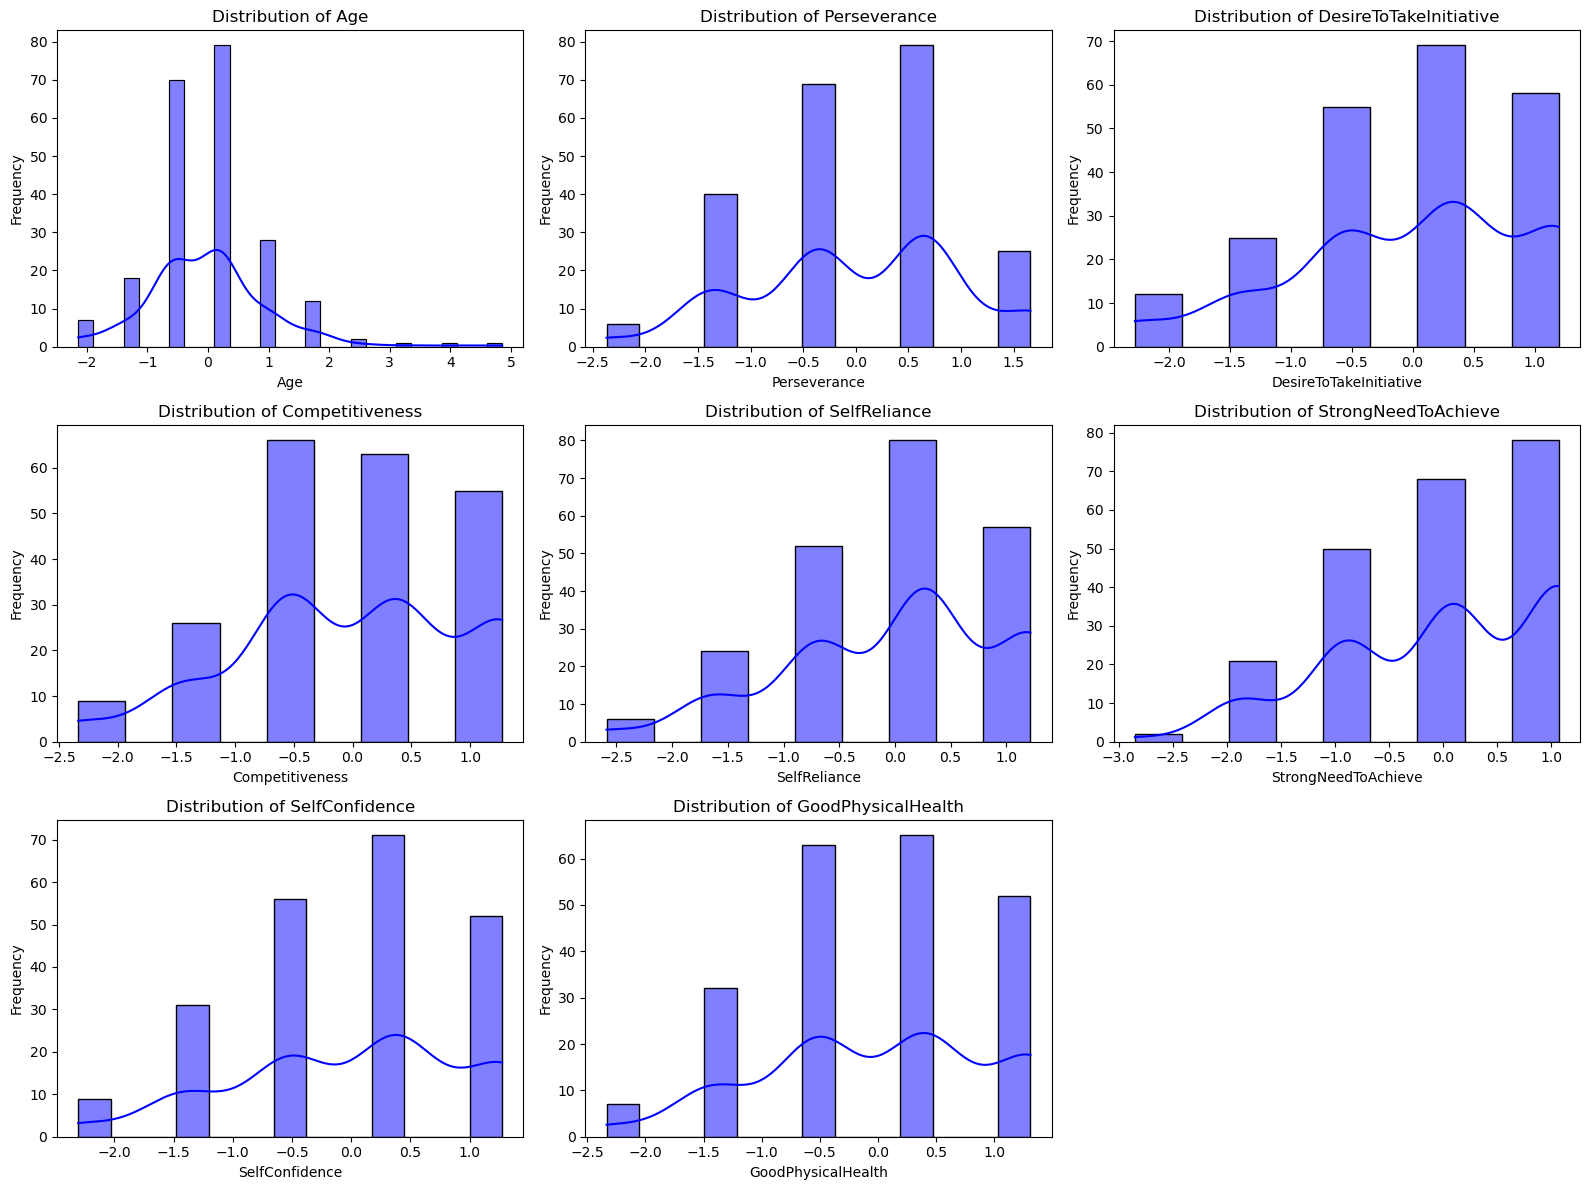

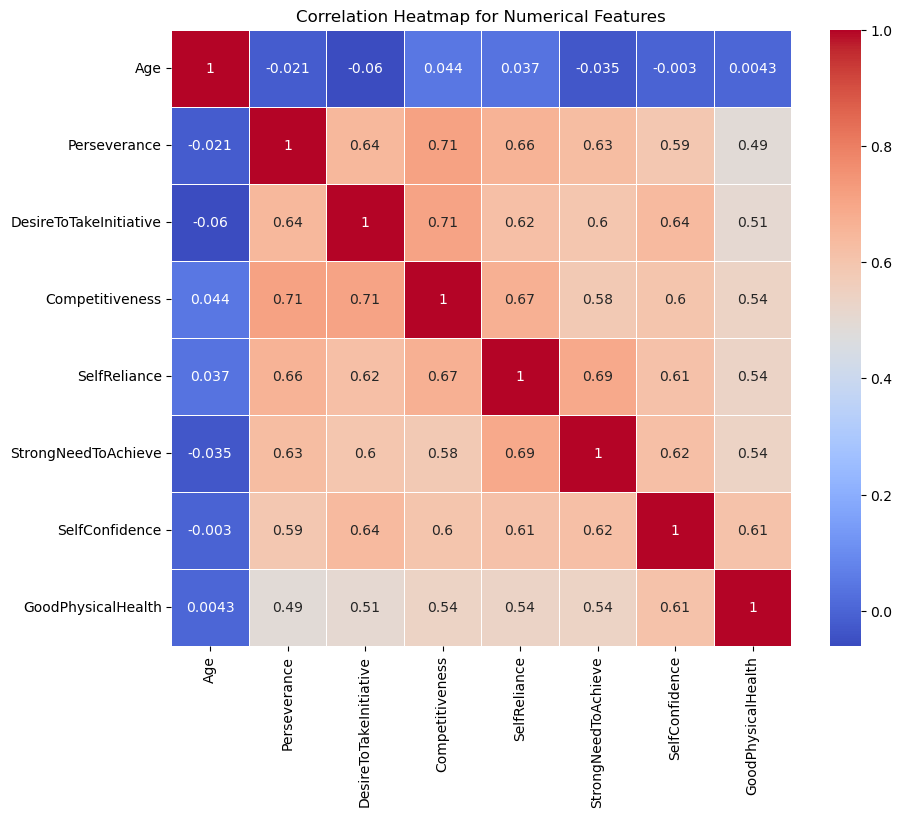

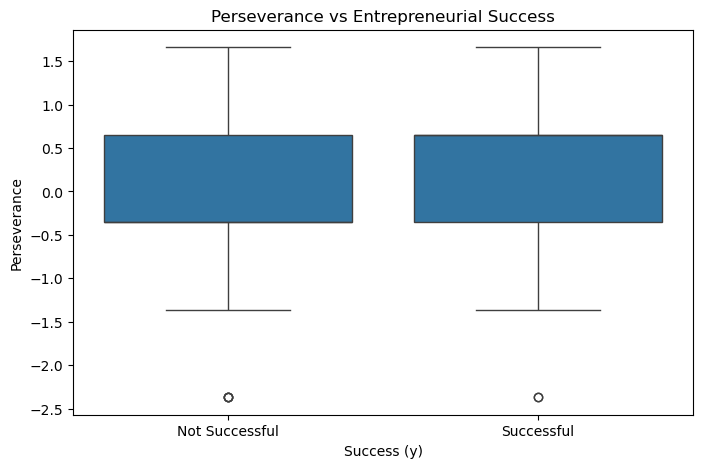

In [6]:
# Step 3: Exploratory Data Analysis
# 3.1 Summary Statistics
print(X.describe())

# 3.2 Data Visualization
# Distribution plots for numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(X[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

# Compare Perseverance for Successful vs Non-Successful Entrepreneurs
plt.figure(figsize=(8, 5))
sns.boxplot(x=y, y=X['Perseverance'])
plt.title('Perseverance vs Entrepreneurial Success')
plt.xlabel('Success (y)')
plt.ylabel('Perseverance')
plt.xticks([0, 1], ['Not Successful', 'Successful'])
plt.show()

In [7]:
# Step 4: Model Selection and Training

# Step 4.1: Random Forest Model Training
# Initialize and Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest Model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Random Forest Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

# Step 4.2: XGBoost Model Training
# Initialize and Train XGBoost Model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

Random Forest Accuracy: 0.61
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71        26
           1       0.55      0.33      0.41        18

    accuracy                           0.61        44
   macro avg       0.59      0.57      0.56        44
weighted avg       0.60      0.61      0.59        44

Random Forest Confusion Matrix:
[[21  5]
 [12  6]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [8]:
# Evaluate XGBoost Model
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))
print('XGBoost Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.59
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.77      0.69        26
           1       0.50      0.33      0.40        18

    accuracy                           0.59        44
   macro avg       0.56      0.55      0.54        44
weighted avg       0.57      0.59      0.57        44

XGBoost Confusion Matrix:
[[20  6]
 [12  6]]


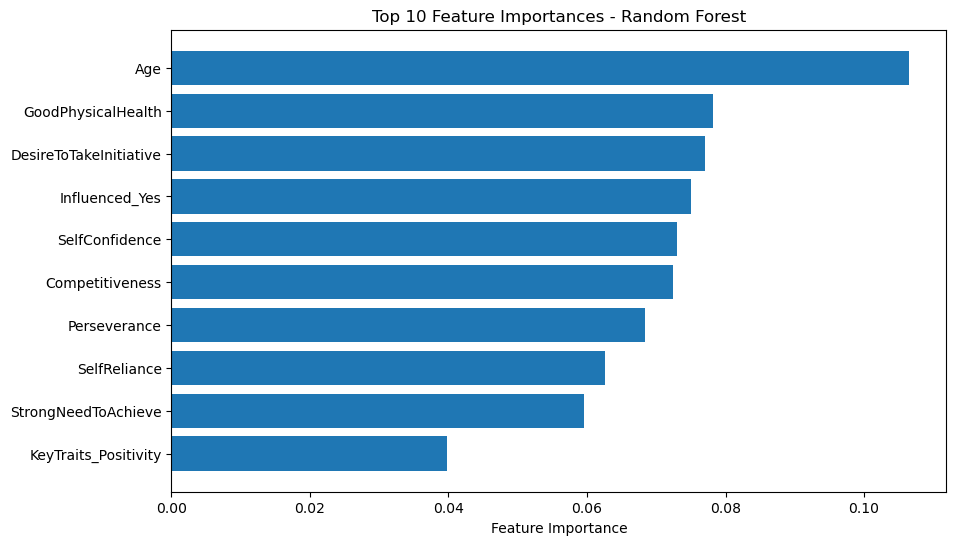

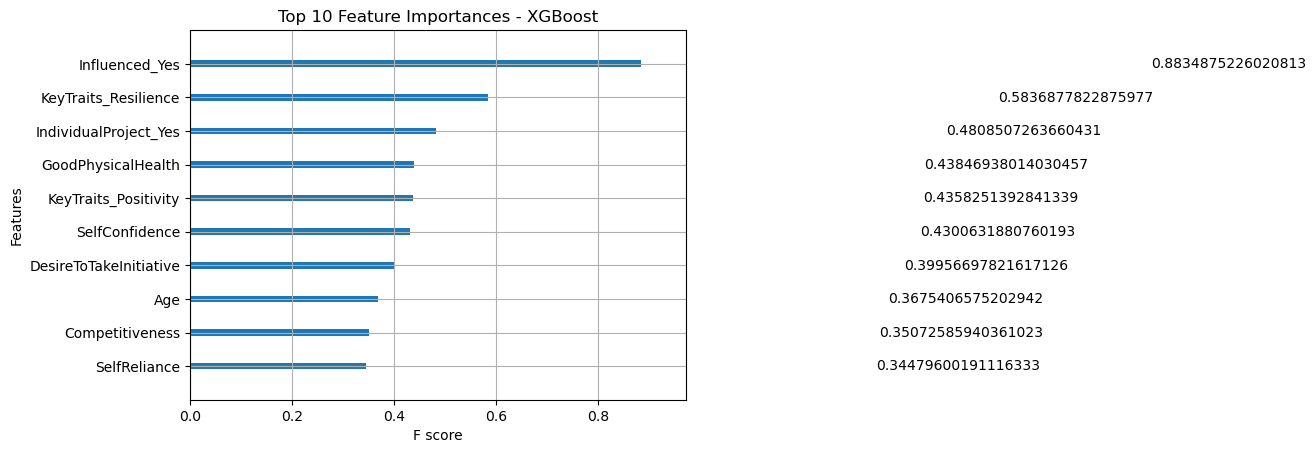

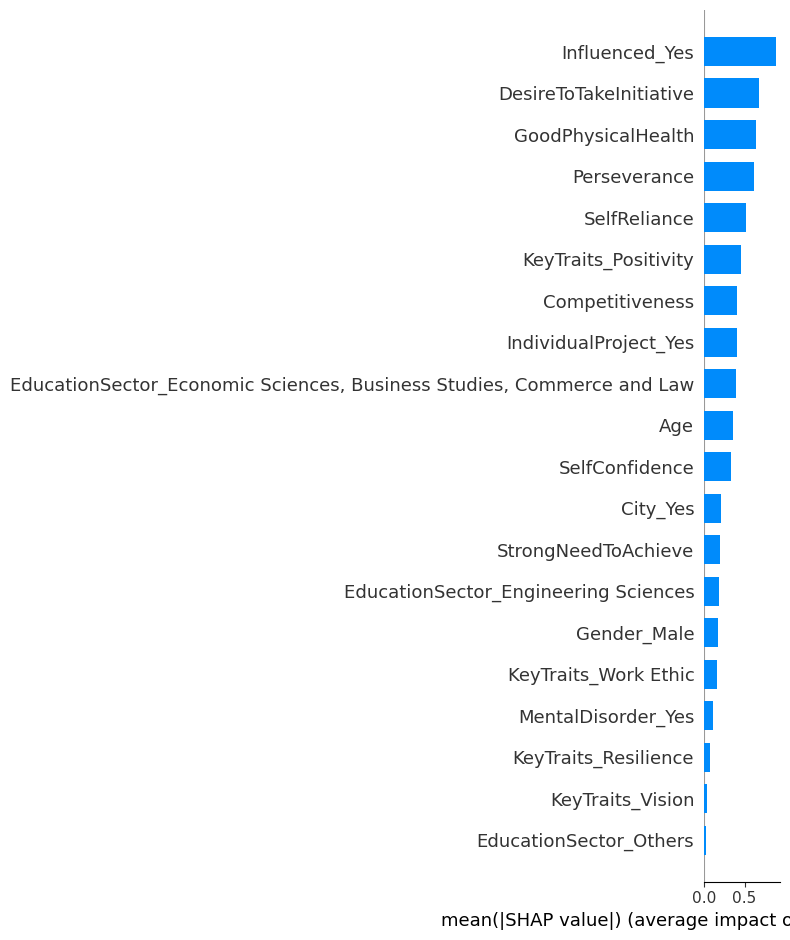

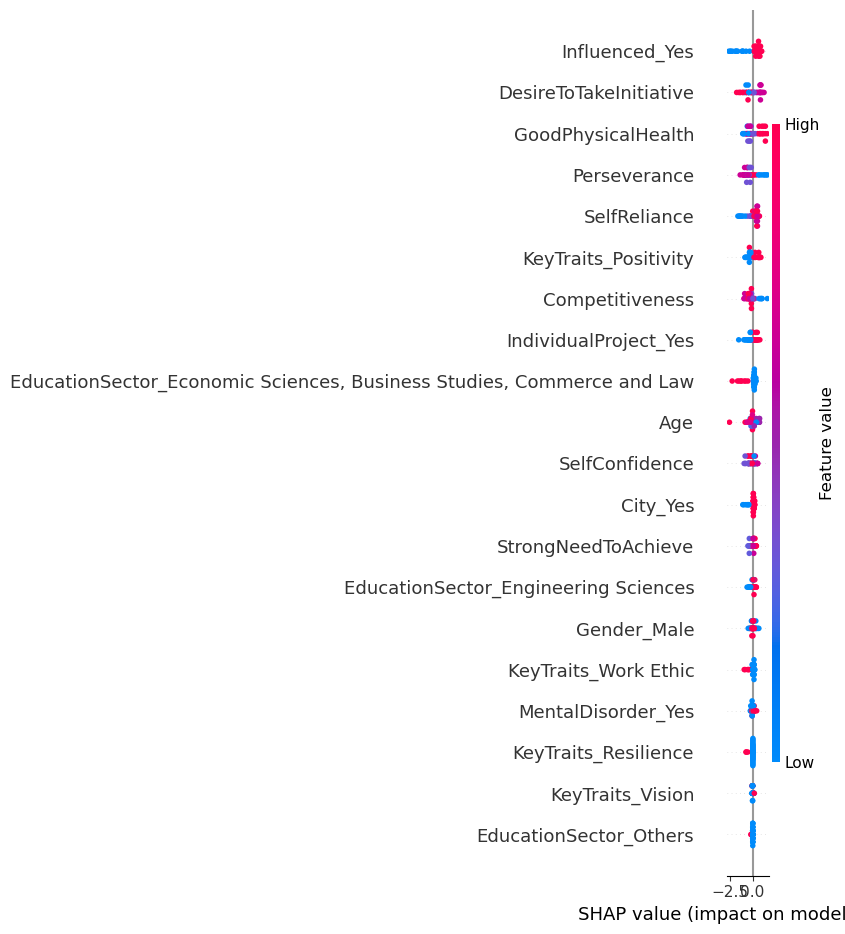

In [9]:
# Step 7: Model Interpretation
# 7.1 Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]  # Get indices of top 10 features
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()

# 7.2 Feature Importance with XGBoost
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances - XGBoost')
plt.show()

# SHAP Analysis for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plots
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [10]:
# Step 8: Statistical Analysis of Traits
# Example t-test for Perseverance
successful = X_train[y_train == 1]['Perseverance']
non_successful = X_train[y_train == 0]['Perseverance']
t_stat, p_value = ttest_ind(successful, non_successful)
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: -0.26983779695461796, p-value: 0.7876066430425195


In [11]:
# Step 9: Conclusion and Recommendations
# Summary of key findings in print format
print("Key Traits for Entrepreneurial Success:")
print("1. Perseverance: Significant positive impact on success.")
print("2. SelfConfidence: Highly correlated with success.")
print("3. Desire to Take Initiative: Strong indicator of entrepreneurial capability.")

Key Traits for Entrepreneurial Success:
1. Perseverance: Significant positive impact on success.
2. SelfConfidence: Highly correlated with success.
3. Desire to Take Initiative: Strong indicator of entrepreneurial capability.


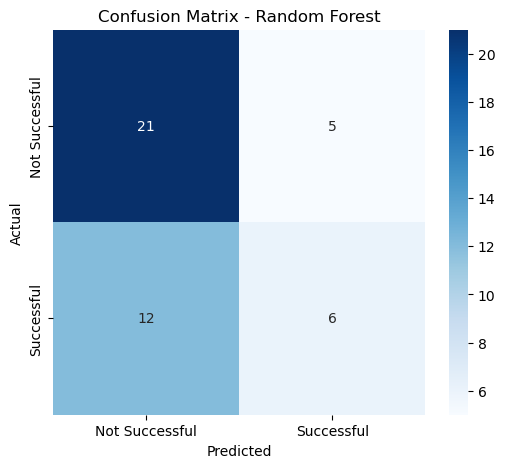

In [12]:
# Step 10: Reporting & Visualization
# Confusion Matrix Visualization for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

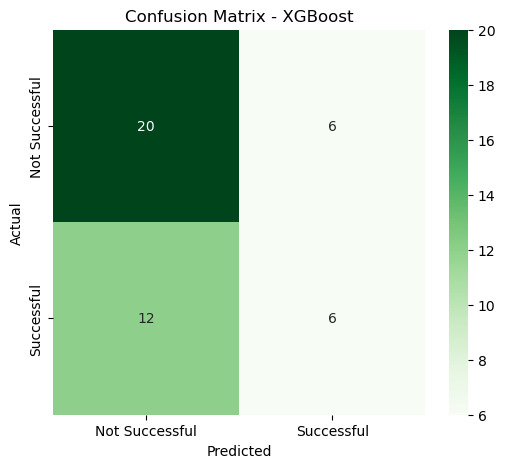

In [13]:
# Confusion Matrix Visualization for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap='Greens', 
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()